## Inpainting Stable Diffusion XL with DreamBooth and LoRA 🧨

## Setup 🪓

In [1]:
# Check the GPU
!nvidia-smi

Fri Jan 26 07:44:29 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A10G         On   | 00000000:00:1E.0 Off |                    0 |
|  0%   37C    P0   163W / 300W |  11636MiB / 23028MiB |    100%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# Install dependencies.
!pip install -U bitsandbytes transformers accelerate datasets peft

In [1]:
!pip install git+https://github.com/huggingface/diffusers.git

Download diffusers SDXL DreamBooth training script.

In [ ]:
!wget https://raw.githubusercontent.com/huggingface/diffusers/main/examples/dreambooth/train_dreambooth_lora_sdxl.py

## Dataset 🐶

In [1]:
import os

# pick a name for the image folder
item = 'bracelet'
model = "stabilityai/stable-diffusion-xl-base-1.0"
instance_dir = f"images/{item}/"
img_extension = 'jpeg'
output_dir = f'dreambooth_sdxl/{item}'
instance_prompt = f"photo of a sks {item}"
ckpt_path = f'{output_dir}/dreambooth_{item}.safetensors'
fp16 = True

os.makedirs(output_dir, exist_ok=True)
!rm -rf $instance_dir/.ipynb_checkpoints
!rm -rf output_dir

Preview the images:

In [2]:
from PIL import Image

def image_grid(imgs, rows, cols, resize=256):

    if resize is not None:
        imgs = [img.resize((resize, resize)) for img in imgs]
    w, h = imgs[0].size
    grid = Image.new("RGB", size=(cols * w, rows * h))
    grid_w, grid_h = grid.size

    for i, img in enumerate(imgs):
        grid.paste(img, box=(i % cols * w, i // cols * h))
    return grid

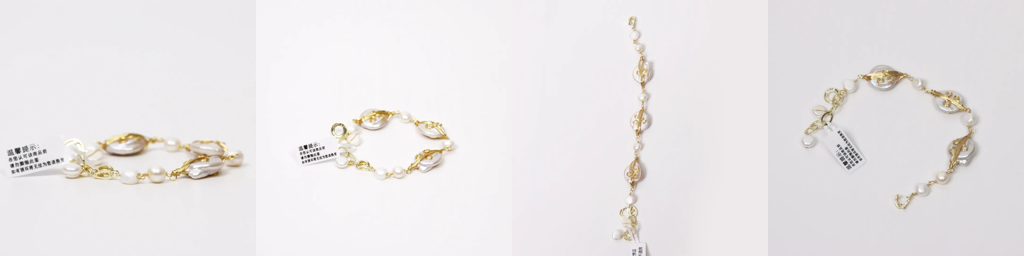

In [5]:
import glob

# change path to display images from your local dir
img_paths = f"{instance_dir}*.{img_extension}"
imgs = [Image.open(path) for path in glob.glob(img_paths)]

num_imgs_to_preview = 4
image_grid(imgs[:num_imgs_to_preview], 1, num_imgs_to_preview)

## Train! 🔬

#### Set Hyperparameters ⚡
To ensure we can DreamBooth with LoRA on a heavy pipeline like Stable Diffusion XL, we're using:

* Gradient checkpointing (`--gradient_accumulation_steps`)
* 8-bit Adam (`--use_8bit_adam`)
* Mixed-precision training (`--mixed-precision="fp16"`)

### Launch training 🚀🚀🚀

In [4]:
#!/usr/bin/env bash
!accelerate launch train_dreambooth_lora_sdxl.py \
  --pretrained_vae_model_name_or_path="madebyollin/sdxl-vae-fp16-fix"
  --pretrained_model_name_or_path=$model \
  --instance_data_dir=$instance_dir \
  --output_dir=$output_dir \
  --instance_prompt="$instance_prompt" \
  --resolution=1024 \
  --train_batch_size=1 \
  --gradient_accumulation_steps=3 \
  --gradient_checkpointing \
  --learning_rate=1e-4 \
  --snr_gamma=5.0 \
  --lr_scheduler="constant" \
  --lr_warmup_steps=0 \
  --mixed_precision="fp16" \
  --use_8bit_adam \
  --max_train_steps=400 \
  --seed="0"

/opt/conda/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/opt/conda/lib/python3.10/site-packages/torchvision/image.so: undefined symbol: _ZN3c104cuda9SetDeviceEi'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
01/26/2024 05:52:59 - INFO - __main__ - Distributed environment: NO
Num processes: 1
Process index: 0
Local process index: 0
Device: cuda

Mixed precision type: fp16

You are using a model of type clip_text_model to instantiate a model of type . This is not supported for all configurations of models and can yield errors.
You are using a model of type clip_text_model to instantiate a model of type . This is not supported for all configurations of models and can yield errors.
{'clip_sample_range', 'rescale_beta

## Inference 🐕

In [2]:
import torch
from diffusers import DiffusionPipeline, AutoencoderKL

vae = AutoencoderKL.from_pretrained("madebyollin/sdxl-vae-fp16-fix", torch_dtype=torch.float16)
pipe = DiffusionPipeline.from_pretrained(
    "stabilityai/stable-diffusion-xl-base-1.0",
    vae=vae,
    torch_dtype=torch.float16,
    variant="fp16",
    use_safetensors=True
)
pipe.load_lora_weights(output_dir)
_ = pipe.to("cuda")

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

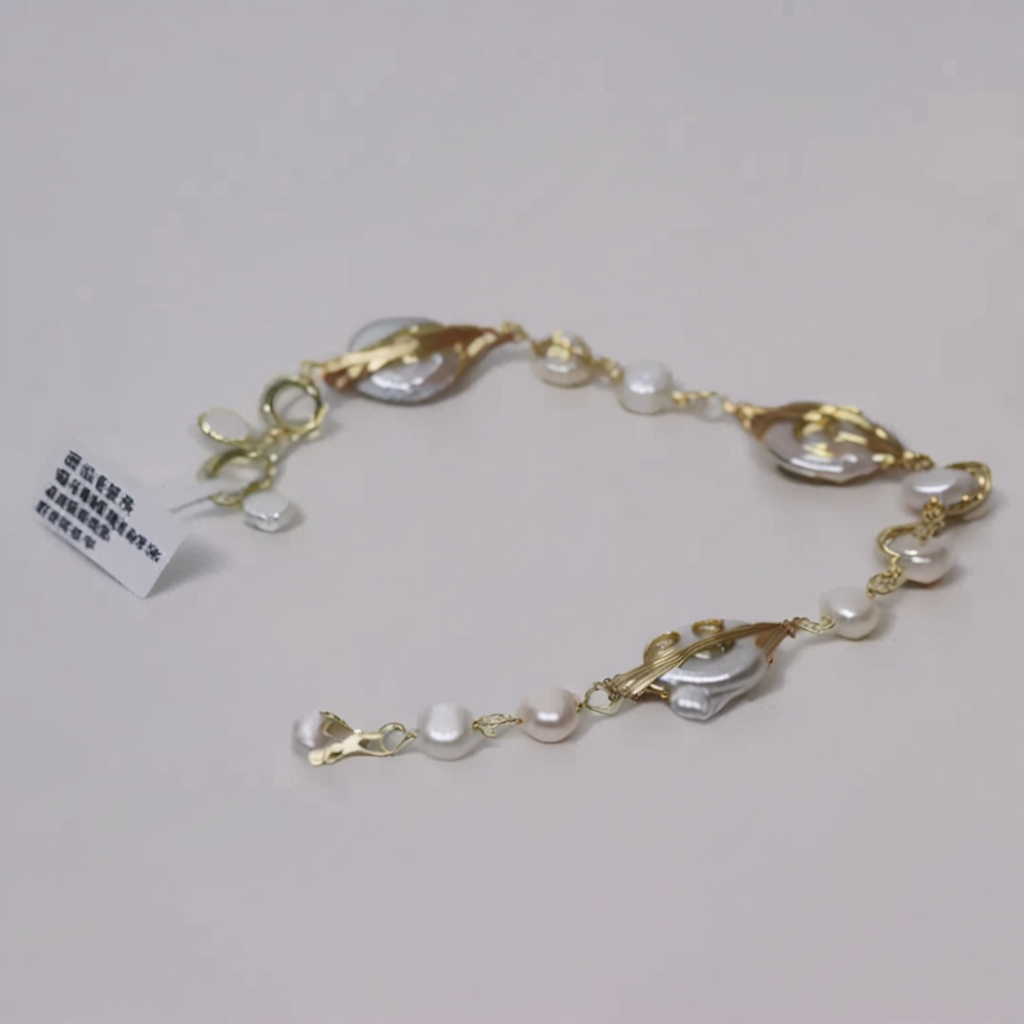

In [3]:
prompt = "a photo of sks bracelet"

image = pipe(prompt=prompt, num_inference_steps=25).images[0]
image

  0%|          | 0/20 [00:00<?, ?it/s]

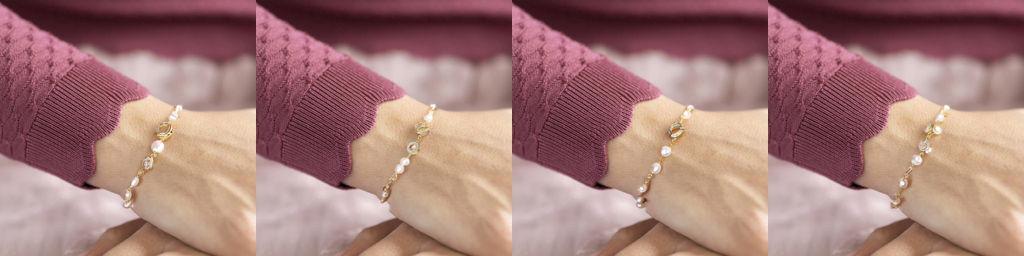

In [17]:
import torch
from diffusers import StableDiffusionXLInpaintPipeline, DiffusionPipeline, AutoencoderKL
from diffusers.utils import load_image
from PIL import Image


vae = AutoencoderKL.from_pretrained("madebyollin/sdxl-vae-fp16-fix", torch_dtype=torch.float16)
pipe = StableDiffusionXLInpaintPipeline.from_pretrained(
    "stabilityai/stable-diffusion-xl-base-1.0", vae=vae, torch_dtype=torch.float16, variant="fp16", use_safetensors=True
)
pipe.load_lora_weights(output_dir)
pipe.to("cuda")

init_image = Image.open('images/inpaint/bracelet.webp').convert("RGB")
mask_image = Image.open('images/inpaint/bracelet_mask.webp').convert("RGB")  #load_image(mask_url).convert("RGB")

prompt = ["A sks bracelet on the wrist of a woman, pleasant to see, high-end, chic, well-designed, crystal clear, beautiful"] * 4
images = pipe(prompt=prompt, image=init_image, mask_image=mask_image, num_inference_steps=40, strength=0.5).images
image_grid(images, 1, 4)